<a href="https://colab.research.google.com/github/superspray/TA/blob/main/bert_beep_ipynb%EC%9D%98_0731_f1%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **네이버 영화리뷰 감정분석 with Hugging Face BERT**

BERT(Bidirectional Encoder Representations from Transformers)는 구글이 개발한 사전훈련(pre-training) 모델입니다. 위키피디아 같은 텍스트 코퍼스를 사용해서 미리 학습을 하면, 언어의 기본적인 패턴을 이해한 모델이 만들어집니다. 이를 기반으로 새로운 문제에 적용하는 전이학습(transfer learning)을 수행합니다. 좀 더 적은 데이터로 보다 빠르게 학습이 가능하다는 장점이 있습니다. 그래서 최근 자연어처리의 핵심 기법으로 떠오르고 있습니다.

이 예제에서는 한글 NLP의 Hello world라고 할 수 있는 네이버 영화리뷰 감정분석을 구현해보겠습니다. 가장 유명한 모델 중 하나인 Hugging Face의 PyTorch BERT를 사용하였습니다. 아래의 Chris McCormick의 블로그를 참조하여 한글에 맞게 수정하였음을 미리 알려드립니다.

< BERT Fine-Tuning Tutorial with PyTorch ><br>
-> https://mccormickml.com/2019/07/22/BERT-fine-tuning
<br>
<br>
<br>
BERT에 대해서 좀 더 자세한 설명은 박상길님과 Jay Alammar의 블로그를 참조하시기 바랍니다.

< BERT 톺아보기 ><br>
-> http://docs.likejazz.com/bert/

< The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning) ><br>
-> http://jalammar.github.io/illustrated-bert/
<br>
<br>


In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 214 kB/s 
     |████████████████████████████████| 448 kB 75.5 MB/s 
     |████████████████████████████████| 86 kB 8.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
from konlpy.tag import Okt

	
if __name__ == '__main__':
    okt = Okt()

    # 출력 값: [('나', 'Noun'), ('는', 'Josa'), ('6시', 'Number'), ('가', 'Foreign'), ('땡', 'Noun'), ('치면', 'Noun'), ('회사', 'Noun'), ('를', 'Josa'), ('나오다', 'Verb'), ('집', 'Noun'), ('으로', 'Josa'), ('가다', 'Verb')]
    print(okt.pos('나는 6시가 땡치면 회사를 나와 집으로 갑니다', stem=True))

[('나', 'Noun'), ('는', 'Josa'), ('6시', 'Number'), ('가', 'Foreign'), ('땡', 'Noun'), ('치면', 'Noun'), ('회사', 'Noun'), ('를', 'Josa'), ('나오다', 'Verb'), ('집', 'Noun'), ('으로', 'Josa'), ('가다', 'Verb')]


In [3]:
print(okt.pos('재고가 많이 재고하다', stem=True))

[('재고', 'Noun'), ('가', 'Josa'), ('많이', 'Adverb'), ('재고', 'Noun'), ('하다', 'Verb')]


<br>
<br>

# **준비 사항**

In [4]:

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

     |████████████████████████████████| 2.6 MB 15.9 MB/s 
     |████████████████████████████████| 3.3 MB 65.4 MB/s 
     |████████████████████████████████| 636 kB 55.6 MB/s 
     |████████████████████████████████| 895 kB 65.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import tensorflow as tf
import torch
from sklearn import metrics

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertForPreTraining, BertPreTrainedModel, BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification

from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn import metrics

import pandas as pd
import numpy as np
import random
import time
import datetime
import pandas as pd
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from transformers import ElectraForMaskedLM
import random
from torch.nn import BCEWithLogitsLoss

from tqdm.notebook import tqdm
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# # train11 =pd.read_csv('ratings_train.txt', sep = '\t').dropna(axis = 0) 
# test11 = pd.read_csv("/content/drive/MyDrive/논문/spell_check_nsmc/train_1.csv").dropna(axis=0) 
# test11[20:40]

<br>
<br>

# **데이터 로드**

In [ ]:
# 판다스로 훈련셋과 테스트셋 데이터 로드

train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_1.csv").dropna(axis=0) 
train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_1.csv").dropna(axis=0) 
train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_1.csv").dropna(axis=0) 

train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
y = pd.get_dummies(train_eda.bias, prefix='bias')
train_eda = pd.concat([train_eda, y], axis = 1)
# train_eda.drop(['document_x', 'doc1'], axis = 1,inplace = True)
# train_eda.rename(columns = {'document_y':'document'},  inplace = True)
print(train_eda.shape)


(5000, 10)


In [28]:
train_beep = pd.read_csv("/content/drive/MyDrive/논문/spell_check_beep/train.csv").dropna(axis=0) 
test_beep = pd.read_csv("/content/drive/MyDrive/논문/spell_check_beep/dev.csv").dropna(axis=0) 
y = pd.get_dummies(train_beep.bias, prefix='bias')
train_beep = pd.concat([train_beep, y], axis =1 )

y = pd.get_dummies(test_beep.hate, prefix='hate')
test_beep = pd.concat([test_beep, y], axis =1 )
test_beep.head()

,comments,contain_gender_bias,bias,hate,id,hate_hate,hate_none,hate_offensive
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none,7896,0,1,0
1,지현우 나쁜놈,False,none,offensive,7897,0,0,1
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate,7898,1,0,0
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate,7899,1,0,0
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive,7900,0,0,1


In [ ]:
train.bias.value_counts()

none      5148
others    1516
gender    1232
Name: bias, dtype: int64

In [ ]:
test_beep.hate.value_counts()

offensive    189
none         160
hate         122
Name: hate, dtype: int64

# BiLSTM 모델



In [ ]:

# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
mec = Mecab() 
# for i in range(100):
#     mecab.morphs(train_data['document'][i])

# train['document'].map(lambda x : mec.morphs(x))
mec.morphs("안녕하세요")

['안녕', '하', '세요']

In [ ]:
train_data = train_
test_data = test_beep
# 한글과 공백을 제외하고 모두 제거
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['comments'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['comments'], inplace=True) # 중복 제거
test_data['comments'] = test_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['comments'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

test_data.dropna(inplace = True)
train_data.dropna(inplace = True)


stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

mecab = Mecab() 

train_data['tokenized'] = train_data['comments'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['comments'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
train_data.head()

NameError: ignored

In [ ]:
train_data = train_eda

test_data = test_beep
test_data['document'] = test_data['comments']
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['document'], inplace=True) # 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

test_data.dropna(inplace = True)
train_data.dropna(inplace = True)


stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

mecab = Mecab() 

train_data['tokenized'] = train_data['document'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['document'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
train_data.head()

id                     0
document               0
comments               0
contain_gender_bias    0
bias                   0
hate                   0
comments1              0
bias_gender            0
bias_none              0
bias_others            0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 471


,id,document,comments,contain_gender_bias,bias,hate,comments1,bias_gender,bias_none,bias_others,tokenized
0,5151,오다 아니다 다르다 타이틀 보고 예상 하다 댓글 계집 년 펄 악플 처 갈기고 있다...,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처갈기고 있었네 ㅋㅋㅋㅋ ...,True,gender,hate,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처 갈기고 있었네 ㅋㅋㅋㅋ...,1,0,0,"[오다, 아니, 다르, 타이틀, 보, 예상, 댓글, 계집, 년, 펄, 악, 플, 처..."
1,5151,오다 아니다 다르다 제목 보고 예상 하다 댓글 계집 년 들 악플 처 예기 갈기 고 ...,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처갈기고 있었네 ㅋㅋㅋㅋ ...,True,gender,hate,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처 갈기고 있었네 ㅋㅋㅋㅋ...,1,0,0,"[오다, 아니, 다르, 제목, 보, 예상, 댓글, 계집, 년, 악, 플, 처, 예기..."
2,5151,오다 갈기고 다르다 제목 보고 예상 하다 댓글 계집 년 들 악플 빨아 아니다 있다 ...,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처갈기고 있었네 ㅋㅋㅋㅋ ...,True,gender,hate,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처 갈기고 있었네 ㅋㅋㅋㅋ...,1,0,0,"[오, 갈기, 다르, 제목, 보, 예상, 댓글, 계집, 년, 악, 플, 빨, 아, ..."
3,5151,오다 아니다 다르다 제목 보고 예상 하다 댓글 계집 년 들 악플 처 갈기고 있다 ㅋ...,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처갈기고 있었네 ㅋㅋㅋㅋ ...,True,gender,hate,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처 갈기고 있었네 ㅋㅋㅋㅋ...,1,0,0,"[오다, 아니, 다르, 제목, 보, 예상, 댓글, 계집, 년, 악, 플, 처, 갈기..."
4,5151,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처 갈기고 있었네 ㅋㅋㅋㅋ...,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처갈기고 있었네 ㅋㅋㅋㅋ ...,True,gender,hate,와 아니나 다를까 제목보고 예상했는데 댓글 계집년들 악플 처 갈기고 있었네 ㅋㅋㅋㅋ...,1,0,0,"[아니, 나, 다를까, 제목, 보고, 예상, 했, 는데, 댓글, 계집년, 악, 플,..."


In [ ]:
test_data.iloc[:,np.arange(5,8)].to_numpy()


array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=uint8)

단어 집합(vocabulary)의 크기 : 5441
등장 빈도가 1번 이하인 희귀 단어의 수: 1319
단어 집합에서 희귀 단어의 비율: 24.241867303804447
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8637050852726322
리뷰의 최대 길이 : 49
리뷰의 평균 길이 : 14.1546


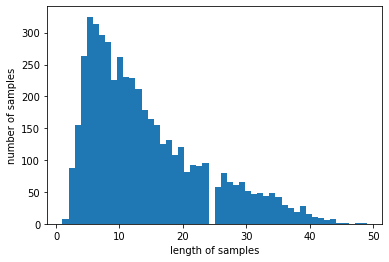

전체 샘플 중 길이가 60 이하인 샘플의 비율: 100.0


In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data.iloc[:,np.arange(-4,-1)].to_numpy()
X_test= test_data['tokenized'].values
y_test = test_data.iloc[:,np.arange(5,8)].to_numpy()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)



threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 60
below_threshold_len(max_len, X_train)


X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)


In [ ]:

import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        true_positives = tf.cast(true_positives, tf.float32)
        possible_positives = tf.cast(possible_positives, tf.float32)
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        true_positives = tf.cast(true_positives, tf.float32)
        predicted_positives = tf.cast(predicted_positives, tf.float32)
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return (2*((precision*recall)/(precision+recall+K.epsilon())))

def create_model():

    model = Sequential()
    model.add(Embedding(vocab_size, 100))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[f1])

    return model

model = create_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[f1])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

loaded_model = load_model('best_model.h5', custom_objects={'f1': [f1]})
print("테스트 정확도: %.4f" % (f1(loaded_model.predict(X_test), y_test).numpy()))

# Train full 사용 ->0.7035
# 333/333/334 개에 eda 한것 ->

Epoch 1/15
16/16 [==============================] - 5s 81ms/step - loss: 0.6337 - f1: 0.0483 - val_loss: 0.6363 - val_f1: 0.0165

Epoch 00001: val_loss improved from inf to 0.63625, saving model to best_model.h5
Epoch 2/15
16/16 [==============================] - 0s 22ms/step - loss: 0.5148 - f1: 0.3732 - val_loss: 0.6557 - val_f1: 0.2280

Epoch 00002: val_loss did not improve from 0.63625
Epoch 3/15
16/16 [==============================] - 0s 22ms/step - loss: 0.3814 - f1: 0.6568 - val_loss: 0.8511 - val_f1: 0.1836

Epoch 00003: val_loss did not improve from 0.63625
Epoch 4/15
16/16 [==============================] - 0s 22ms/step - loss: 0.2876 - f1: 0.8465 - val_loss: 0.8211 - val_f1: 0.2414

Epoch 00004: val_loss did not improve from 0.63625
Epoch 5/15
16/16 [==============================] - 0s 23ms/step - loss: 0.1962 - f1: 0.9205 - val_loss: 0.7821 - val_f1: 0.3946

Epoch 00005: val_loss did not improve from 0.63625
Epoch 00005: early stopping
테스트 정확도: 0.0866


In [ ]:
y_test

array([[0, '송중기 시대극은 믿고본다 첫회 신선하고 좋았다',
        list(['송중기', '시대극', '믿', '본다', '첫', '회', '신선', '좋', '았'])],
       [1, '지현우 나쁜놈', list(['지현우', '나쁜', '놈'])],
       [0, '알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라',
        list(['알', '바', '쓰', '많이', '만들', '돈', '욕심', '없', '으면', '골목', '식당', '왜', '나', '온겨', '기', '댕기', '나', '하고', '산', '서', '팔', '어라'])],
       ...,
       [1, '근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는',
        list(['근데', '전라도', '에서', '사고', '났', '는데', '굳이', '서울', '까지', '와서', '병원', '가느', '이유'])],
       [0, '할매젖 뱃살 몸매 라인 유륜은 적당해야됨너무크거나 너무 작아도  엉덩이가 빵빵해야됨',
        list(['할매', '젖', '뱃살', '몸매', '라인', '유륜', '적당', '해야', '됨', '너무', '크', '거나', '너무', '작', '아도', '엉덩이', '빵빵', '해야', '됨'])],
       [0, '남자가 잘못한거라면 반성도 없다면나였다면  여자처럼 아주 못되게 할것같다왜 나를 배신한거니까',
        list(['남자', '잘못', '거', '라면', '반성', '없', '다면', '나', '였', '다면', '여자', '처럼', '아주', '못', '할', '것', '같', '왜', '나', '배신', '거', '니까'])]],
      dtype=object)

In [ ]:

model = create_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[f1])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

loaded_model = load_model('best_model.h5', custom_objects={'f1': [f1]})
print("테스트 정확도: %.4f" % (f1(loaded_model.predict(X_test), y_test).numpy()))




<br>
<br>

# **모델 생성**

In [24]:
def data_loader(train, test,train_doc ='document', test_doc = 'comments'):

	# 리뷰 문장 추출
	train = train.dropna( )
	test = test.dropna()
	sentences = train[train_doc]
	sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
	labels = train.loc[:,["hate_hate", 'hate_none', 'hate_offensive']].to_numpy()

	tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
	tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

	MAX_LEN = 128
	input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
	input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
	attention_masks = []
	for seq in input_ids:
	    seq_mask = [float(i>0) for i in seq]
	    attention_masks.append(seq_mask)

	train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
	                                                                                    labels, 
	                                                                                    random_state=2018, 
	                                                                                    test_size=0.2)

	# 어텐션 마스크를 훈련셋과 검증셋으로 분리
	train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
	                                                       input_ids,
	                                                       random_state=2018, 
	                                                       test_size=0.2)

	# 데이터를 파이토치의 텐서로 변환
	train_inputs = torch.tensor(train_inputs)
	train_labels = torch.tensor(train_labels)
	train_masks = torch.tensor(train_masks)
	validation_inputs = torch.tensor(validation_inputs)
	validation_labels = torch.tensor(validation_labels)
	validation_masks = torch.tensor(validation_masks)				


	# 배치 사이즈
	batch_size = 32

	# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
	# 학습시 배치 사이즈 만큼 데이터를 가져옴
	train_data = TensorDataset(train_inputs, train_masks, train_labels)
	train_sampler = RandomSampler(train_data)
	train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

	validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
	validation_sampler = SequentialSampler(validation_data)
	validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


	# TEST DATA
	sentences = test[test_doc ]
	sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
	labels = test.loc[:,["hate_hate", 'hate_none', 'hate_offensive']].to_numpy()


	tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
	tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

	input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

	input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

	attention_masks = []

	for seq in input_ids:
	    seq_mask = [float(i>0) for i in seq]
	    attention_masks.append(seq_mask)


	test_inputs = torch.tensor(input_ids)
	test_labels = torch.tensor(labels)
	test_masks = torch.tensor(attention_masks)

	batch_size = 32

	# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
	# 학습시 배치 사이즈 만큼 데이터를 가져옴
	test_data = TensorDataset(test_inputs, test_masks, test_labels)
	test_sampler = RandomSampler(test_data)
	test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
 
	return train_data, validation_data, train_dataloader, validation_dataloader, test_dataloader



In [11]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()

In [8]:

import torch
import torch.nn as nn
# loss_fn = nn.CrossEntropyLoss() 
loss_fn = BCEWithLogitsLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:

def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1) # axis = 1 will check for equality along rows.
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n
emr(np.array([[1,0,1],[1,0,0]]), np.array([[True, False, False],[True,False,False]]))

0.5

In [12]:

def train_model(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, patience = 5):

	optimizer = AdamW(model.parameters(),
					lr = 2e-5, # 학습률
					eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
					)
	# 총 훈련 스텝 : 배치반복 횟수 * 에폭
	total_steps = len(train_dataloader) * epochs

	# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
	scheduler = get_linear_schedule_with_warmup(optimizer, 
											num_warmup_steps = 0,
											num_training_steps = total_steps)
	print("Start training...\n")

	early_stopping = EarlyStopping(patience = patience, verbose = True)
    

	for epoch_i in range(epochs):

		# =======================================
		#               Training
		# =======================================
		# Print the header of the result table
		print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
		print("-"*70)


		# Measure the elapsed time of each epoch
		t0_epoch, t0_batch = time.time(), time.time()

		# Reset tracking variables at the beginning of each epoch
		total_loss, batch_loss, batch_counts, train_accuracy = 0, 0, 0, []

		# Put the model into the training mode
		model.train()


		for step, batch in enumerate(train_dataloader):

			batch_counts +=1
			b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

			model.zero_grad()

			outputs= model(b_input_ids, 
							# token_type_ids=None, 
							attention_mask=b_attn_mask, 
							labels=b_labels.to(torch.float64))
			loss = outputs[0]
			batch_loss += loss.item()
			total_loss += loss.item()

			loss.backward()

			logits = outputs[1]
			preds = np.array(logits.cpu().detach()) >= 0.5
			# accuracy = metrics.accuracy_score(b_labels.cpu(), preds) *100 #EMR

			# Calculate the accuracy rate
			# train_accuracy.append(accuracy)

			# Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
			torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

			# 그래디언트를 통해 가중치 파라미터 업데이트
			optimizer.step()
			scheduler.step()


			# # Print the loss values and time elapsed for every 20 batches
			# if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
			# 	# Calculate time elapsed for 20 batches
			# 	time_elapsed = time.time() - t0_batch

			# 	# Print training results
			# 	print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

			# 	# Reset batch tracking variables
			# 	batch_loss, batch_counts = 0, 0
			# 	t0_batch = time.time()
		# Calculate the average loss over the entire training data
		avg_train_loss = total_loss / len(train_dataloader)
		# avg_train_acc =  np.mean(train_accuracy)

		# print("-"*70)
		# print("")
		# print("  Average training loss: {0:.2f}".format(avg_train_loss))
		# print("  Training epoch took: {:}".format(format_time(time.time() - t0_epoch)))

		# ========================================
		#               Validation
		# ========================================
		if evaluation == True:

			# on our validation set.
			val_loss, val_accuracy = evaluate(model, val_dataloader)[:2]
			# Print performance over the entire training data
			time_elapsed = time.time() - t0_epoch

			print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
			print("-"*70)
		else:
			time_elapsed = time.time() - t0_epoch

			print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {'-':^10}| {'-':^10}| {time_elapsed:^9.2f}")
			print("-"*70)

		print("\n")

		early_stopping(val_loss, model)

		if early_stopping.early_stop:
			print("Early stopping")
			break

	# best model이 저장되어있는 last checkpoint를 로드한다.
	model.load_state_dict(torch.load('checkpoint.pt'))


	print("Training complete!")
	return model


def evaluate(model, val_dataloader, test_mode = False):

    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    all_logits = []
    targets = []
    outputs = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)[0]


        # Compute loss
        loss = loss_fn(logits, b_labels.to(torch.float64))
        val_loss.append(loss.item())

        # Get the predictions
        preds = np.array(logits.cpu().detach()) >= 0.5


        # Calculate the accuracy rate
        # accuracy = metrics.accuracy_score(b_labels.cpu(), preds) *100 #EMR
        # accuracy = metrics.f1_score(b_labels.cpu(), preds,average='macro') 
        accuracy = metrics.f1_score(b_labels.cpu(), preds, average='micro')
        # accuracy = metrics.f1_score(b_labels.cpu(), preds, average='weighted') 
        # accuracy = metrics.f1_score(b_labels.cpu(), preds, average='samples') 
        
        val_accuracy.append(accuracy)
        # all_logits.append(logits)

        
        outputs.append(preds)
        targets.append(b_labels.cpu())
    
    outputs = np.concatenate(outputs)
    targets = np.concatenate(targets)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = metrics.f1_score(outputs, targets, average= "micro")
    
    # Concatenate logits from each batch
    # all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    # probs = F.softmax(all_logits, dim=1).cpu().numpy()

    if test_mode:
        print(metrics.classification_report(outputs, targets, digits=3))
        print("Accuracy: {0:.3f}".format(metrics.f1_score(outputs, targets, average="micro")))

    return val_loss, val_accuracy


In [13]:

def full_train_test(train_dataloader, validation_dataloader,test_dataloader, epochs, model=model):
	# Concatenate the train set and the validation set
	# full_train_data = torch.utils.data.ConcatDataset([train_data, validation_data])
	# full_train_sampler = RandomSampler(train_data)
	# full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

	# Train the Bert Classifier on the entire training data
	set_seed(42)
	model_trained = train_model(model, train_dataloader, validation_dataloader, epochs=epochs, evaluation = True)

	t0 = time.time()
	test_result = evaluate(model_trained, test_dataloader, test_mode =  True) 
	print("")
	print("Accuracy: {0:.3f}".format(test_result[1]))
	print("Loss: {0:.3f}".format(test_result[0]))
	print("Test took: {:}".format(format_time(time.time() - t0)))

	return test_result[0], test_result[1], model


In [25]:

def final(train, test, train_doc= 'document', test_doc='comments', epochs = 2, model=model):
    train_data, validation_data, train_dataloader, validation_dataloader, test_dataloader = data_loader(train, test, train_doc=train_doc, test_doc=test_doc)
    full_result = full_train_test(train_dataloader, validation_dataloader, test_dataloader, epochs = epochs)
    print(full_result[:2])
    return full_result

# Hate

In [ ]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 100
for j in range(5):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


In [37]:
np.sqrt(5)

2.23606797749979

In [35]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 200
for j in range(5):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.100181   |  0.000744  |   1.00    |   12.77  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000744).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.004906   |  0.000484  |   1.00    |   12.75  
----------------------------------------------------------------------


Validation loss decreased (0.000744 --> 0.000484).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000508   |  0.000432  |   1.00    |   12.73  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.484     0.551     0.515       107
           1      0.569     0.435     0.493       209
           2      0.302     0.385     0.338       148

   micro avg      0.439     0.446     0.443       464
   macro avg      0.451     0.457     0.449       464
weighted avg      0.464     0.446     0.449       464
 samples avg      0.439     0.439     0.439       464

Accuracy: 0.443

Accuracy: 0.443
Loss: 2.600
Test took: 0:00:02
(2.5999499554559424, 0.44278074866310163)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.975223   |  0.280543  |   0.78    |   12.83  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.280543).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.459     0.459     0.459       122
           1      0.575     0.465     0.514       198
           2      0.302     0.425     0.353       134

   micro avg      0.435     0.452     0.443       454
   macro avg      0.445     0.450     0.442       454
weighted avg      0.463     0.452     0.452       454
 samples avg      0.435     0.435     0.435       454

Accuracy: 0.443

Accuracy: 0.443
Loss: 2.306
Test took: 0:00:02
(2.306032561667812, 0.44324324324324327)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.601312   |  0.099328  |   0.96    |   12.83  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.099328).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.451     0.519     0.482       106
           1      0.637     0.531     0.580       192
           2      0.386     0.451     0.416       162

   micro avg      0.488     0.500     0.494       460
   macro avg      0.492     0.500     0.493       460
weighted avg      0.506     0.500     0.500       460
 samples avg      0.488     0.487     0.488       460

Accuracy: 0.494

Accuracy: 0.494
Loss: 2.183
Test took: 0:00:02
(2.182559394284638, 0.4940923737916219)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.848923   |  0.211283  |   0.87    |   12.91  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.211283).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.541     0.537     0.539       123
           1      0.725     0.542     0.620       214
           2      0.317     0.492     0.386       122

   micro avg      0.514     0.527     0.520       459
   macro avg      0.528     0.523     0.515       459
weighted avg      0.567     0.527     0.536       459
 samples avg      0.514     0.514     0.514       459

Accuracy: 0.520

Accuracy: 0.520
Loss: 2.203
Test took: 0:00:02
(2.2028867049879013, 0.5204301075268817)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.864845   |  0.235014  |   0.85    |   12.85  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.235014).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 500
for j in range(5):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


In [ ]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 1000
for j in range(5):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.144939   |  0.044289  |   0.98    |   64.15  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.044289).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.042238   |  0.006004  |   0.99    |   63.91  
----------------------------------------------------------------------


Validation loss decreased (0.044289 --> 0.006004).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.021086   |  0.000241  |   1.00    |   63.75  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.590     0.550     0.569       131
           1      0.731     0.571     0.641       205
           2      0.392     0.574     0.465       129

   micro avg      0.558     0.566     0.562       465
   macro avg      0.571     0.565     0.559       465
weighted avg      0.597     0.566     0.572       465
 samples avg      0.558     0.558     0.558       465

Accuracy: 0.562

Accuracy: 0.562
Loss: 2.186
Test took: 0:00:02
(2.1858350456185645, 0.561965811965812)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.256483   |  0.074203  |   0.97    |   64.07  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.074203).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.566     0.580     0.573       119
           1      0.725     0.547     0.624       212
           2      0.349     0.489     0.407       135

   micro avg      0.533     0.539     0.536       466
   macro avg      0.547     0.539     0.535       466
weighted avg      0.575     0.539     0.548       466
 samples avg      0.533     0.533     0.533       466

Accuracy: 0.536

Accuracy: 0.536
Loss: 2.380
Test took: 0:00:02
(2.380268415581326, 0.535752401280683)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.254705   |  0.036521  |   0.99    |   64.09  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.036521).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.418     0.573     0.483        89
           1      0.769     0.542     0.636       227
           2      0.370     0.479     0.418       146

   micro avg      0.518     0.528     0.523       462
   macro avg      0.519     0.531     0.512       462
weighted avg      0.575     0.528     0.538       462
 samples avg      0.518     0.518     0.518       462

Accuracy: 0.523

Accuracy: 0.523
Loss: 2.405
Test took: 0:00:02
(2.4051993427299037, 0.5230439442658092)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.271862   |  0.063186  |   0.98    |   64.09  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.063186).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

## Hate original

In [ ]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 100
for j in range(5):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    # train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


In [ ]:
test_beep.bias.value_counts()

In [41]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 200
for j in range(5):
    print(j)
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    # train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.153407   |  0.033564  |   0.96    |   2.14   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.033564).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.034013   |  0.008354  |   0.99    |   2.14   
----------------------------------------------------------------------


Validation loss decreased (0.033564 --> 0.008354).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.005013   |  0.003650  |   1.00    |   2.14   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.557     0.496     0.525       137
           1      0.600     0.533     0.565       180
           2      0.328     0.481     0.390       129

   micro avg      0.480     0.507     0.493       446
   macro avg      0.495     0.503     0.493       446
weighted avg      0.508     0.507     0.502       446
 samples avg      0.480     0.480     0.480       446

Accuracy: 0.493

Accuracy: 0.493
Loss: 2.039
Test took: 0:00:02
(2.0385608463298794, 0.49291166848418755)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.240310   |  0.020401  |   0.97    |   2.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.020401).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.525     0.508     0.516       126
           1      0.644     0.502     0.564       205
           2      0.270     0.459     0.340       111

   micro avg      0.463     0.493     0.478       442
   macro avg      0.479     0.490     0.474       442
weighted avg      0.516     0.493     0.494       442
 samples avg      0.463     0.463     0.463       442

Accuracy: 0.478

Accuracy: 0.478
Loss: 1.834
Test took: 0:00:02
(1.8343754215856762, 0.47754654983570644)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.197444   |  0.003981  |   1.00    |   2.16   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.003981).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.426     0.481     0.452       108
           1      0.669     0.507     0.577       211
           2      0.349     0.485     0.406       136

   micro avg      0.478     0.495     0.486       455
   macro avg      0.481     0.491     0.478       455
weighted avg      0.516     0.495     0.496       455
 samples avg      0.478     0.478     0.478       455

Accuracy: 0.486

Accuracy: 0.486
Loss: 2.290
Test took: 0:00:02
(2.289542299899369, 0.48596112311015116)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.012415   |  0.088499  |   0.97    |   2.16   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.088499).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.500     0.449     0.473       136
           1      0.619     0.544     0.579       182
           2      0.360     0.486     0.413       140

   micro avg      0.484     0.498     0.491       458
   macro avg      0.493     0.493     0.488       458
weighted avg      0.504     0.498     0.497       458
 samples avg      0.484     0.484     0.484       458

Accuracy: 0.491

Accuracy: 0.491
Loss: 2.294
Test took: 0:00:02
(2.294226112663787, 0.49085037674919274)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.256947   |  0.354550  |   0.97    |   2.17   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.354550).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 500
for j in range(5):
    print(j)

    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    # train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

0
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.323765   |  0.294256  |   0.78    |   5.40   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.294256).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.179724   |  0.283741  |   0.79    |   5.38   
----------------------------------------------------------------------


Validation loss decreased (0.294256 --> 0.283741).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.112224   |  0.366755  |   0.82    |   5.39   
-------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.418     0.567     0.481        90
           1      0.675     0.545     0.603       198
           2      0.270     0.505     0.352       101

   micro avg      0.446     0.540     0.488       389
   macro avg      0.454     0.539     0.479       389
weighted avg      0.510     0.540     0.510       389
 samples avg      0.446     0.446     0.446       389

Accuracy: 0.488

Accuracy: 0.488
Loss: 0.938
Test took: 0:00:02
(0.937816928742525, 0.4883720930232558)
1
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.291253   |  0.412059  |   0.78    |   5.40   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.412059).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.238     0.580     0.337        50
           1      0.544     0.572     0.558       152
           2      0.370     0.476     0.417       147

   micro avg      0.395     0.533     0.454       349
   macro avg      0.384     0.543     0.437       349
weighted avg      0.427     0.533     0.467       349
 samples avg      0.395     0.395     0.395       349

Accuracy: 0.454

Accuracy: 0.454
Loss: 0.808
Test took: 0:00:02
(0.8079067402587764, 0.4536585365853659)
2
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.265850   |  0.248160  |   0.83    |   5.38   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.248160).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.566     0.556     0.561       124
           1      0.550     0.579     0.564       152
           2      0.217     0.494     0.301        83

   micro avg      0.420     0.552     0.477       359
   macro avg      0.444     0.543     0.476       359
weighted avg      0.478     0.552     0.502       359
 samples avg      0.420     0.420     0.420       359

Accuracy: 0.477

Accuracy: 0.477
Loss: 0.830
Test took: 0:00:02
(0.8297155188224097, 0.4771084337349398)
3
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.286227   |  0.337189  |   0.82    |   5.40   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.337189).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.467     0.594     0.523        96
           1      0.675     0.562     0.614       192
           2      0.164     0.525     0.250        59

   micro avg      0.416     0.565     0.479       347
   macro avg      0.435     0.561     0.462       347
weighted avg      0.531     0.565     0.527       347
 samples avg      0.416     0.416     0.416       347

Accuracy: 0.479

Accuracy: 0.479
Loss: 0.795
Test took: 0:00:02
(0.7947192960066245, 0.4792176039119805)
4
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.352527   |  0.466773  |   0.78    |   5.38   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.466773).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 1000
for j in range(5):
    print(j)

    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_hate_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/hate/eda_hate_off_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.hate, prefix='hate')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
    train_sf = shuffle(train1000, random_state = j).reset_index(drop = True)[:n]
    train_sf['document'] = train_sf.comments
    train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
    # train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

    result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)

print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std()/np.sqrt(5), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

0
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.219079   |  0.465287  |   0.72    |   10.74  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.465287).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.138291   |  0.529084  |   0.74    |   10.72  
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.112383   |  0.515228  |   0.72    |   10.71  
----------------------------------------------------------------------


EarlyStopping counter: 2 out 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.377     0.590     0.460        78
           1      0.562     0.577     0.570       156
           2      0.418     0.488     0.450       162

   micro avg      0.456     0.543     0.496       396
   macro avg      0.453     0.551     0.493       396
weighted avg      0.467     0.543     0.499       396
 samples avg      0.456     0.456     0.456       396

Accuracy: 0.496

Accuracy: 0.496
Loss: 0.918
Test took: 0:00:02
(0.9179046233763232, 0.4959630911188005)
1
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.249025   |  0.310187  |   0.79    |   10.70  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.310187).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.336     0.621     0.436        66
           1      0.625     0.578     0.601       173
           2      0.296     0.479     0.366       117

   micro avg      0.418     0.553     0.476       356
   macro avg      0.419     0.559     0.468       356
weighted avg      0.463     0.553     0.493       356
 samples avg      0.418     0.418     0.418       356

Accuracy: 0.476

Accuracy: 0.476
Loss: 0.794
Test took: 0:00:02
(0.7939718361018824, 0.47642079806529625)
2
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.249977   |  0.343519  |   0.74    |   10.71  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.343519).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.525     0.571     0.547       112
           1      0.644     0.572     0.606       180
           2      0.132     0.581     0.216        43

   micro avg      0.408     0.573     0.476       335
   macro avg      0.434     0.575     0.456       335
weighted avg      0.538     0.573     0.536       335
 samples avg      0.408     0.408     0.408       335

Accuracy: 0.476

Accuracy: 0.476
Loss: 0.775
Test took: 0:00:02
(0.7754287547960044, 0.4764267990074442)
3
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.218303   |  0.428090  |   0.72    |   10.72  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.428090).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.443     0.574     0.500        94
           1      0.550     0.629     0.587       140
           2      0.349     0.475     0.402       139

   micro avg      0.442     0.558     0.493       373
   macro avg      0.447     0.559     0.496       373
weighted avg      0.448     0.558     0.496       373
 samples avg      0.442     0.442     0.442       373

Accuracy: 0.493

Accuracy: 0.493
Loss: 0.904
Test took: 0:00:02
(0.90420073450579, 0.4928909952606635)
4
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.265648   |  0.382108  |   0.74    |   10.73  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.382108).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
test_beep.hate.value_counts()

offensive    189
none         160
hate         122
Name: hate, dtype: int64

# Beep Bias


In [ ]:
# 333 0응로 된것 세개 해서 bias  train eda 1000
# 333 세개 한것 .577

f1_score_list= []
for j in range(3):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.bias, prefix='bias')
    train_eda = pd.concat([train_eda, y], axis = 1)

    result = final(train_eda, test_beep, epochs = 15, model = model)[1]
    f1_score_list.append(result )

train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
y = pd.get_dummies(train_eda.bias, prefix='bias')
train_eda = pd.concat([train_eda, y], axis = 1)

result = final(train_eda, test_beep, epochs = 15, model = model)[1]
f1_score_list.append(result )


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.048289   |  0.019633  |   0.99    |   53.21  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.019633).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.017985   |  0.023990  |   0.99    |   53.03  
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.012939   |  0.026670  |   0.99    |   53.00  
----------------------------------------------------------------------


EarlyStopping counter: 2 out of

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.731     0.598     0.658        82
           1      0.538     0.925     0.680       199
           2      0.790     0.272     0.405       180

   micro avg      0.599     0.612     0.605       461
   macro avg      0.687     0.598     0.581       461
weighted avg      0.671     0.612     0.569       461
 samples avg      0.599     0.599     0.599       461

Accuracy: 0.605

Accuracy: 0.605
Loss: 1.557
Test took: 0:00:02
(1.5566511184014318, 0.6051502145922746)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.055055   |  0.044702  |   0.98    |   53.22  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.044702).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.701     0.595     0.644        79
           1      0.602     0.904     0.723       228
           2      0.758     0.297     0.427       158

   micro avg      0.637     0.645     0.641       465
   macro avg      0.687     0.599     0.598       465
weighted avg      0.672     0.645     0.609       465
 samples avg      0.637     0.637     0.637       465

Accuracy: 0.641

Accuracy: 0.641
Loss: 1.757
Test took: 0:00:02
(1.7570709096527226, 0.641025641025641)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.035956   |  0.129522  |   0.96    |   53.27  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.129522).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.731     0.613     0.667        80
           1      0.678     0.892     0.771       260
           2      0.694     0.347     0.462       124

   micro avg      0.688     0.698     0.693       464
   macro avg      0.701     0.617     0.633       464
weighted avg      0.692     0.698     0.670       464
 samples avg      0.688     0.688     0.688       464

Accuracy: 0.693

Accuracy: 0.693
Loss: 1.381
Test took: 0:00:02
(1.380794248351044, 0.6930481283422459)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.289620   |  0.115047  |   0.95    |   53.31  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.115047).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

In [ ]:
f1_score_list = [.599]
f1_score_list.extend([.605, 0.641, .693])
round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3)

(0.634, 0.037)

In [ ]:
# eda 한것 합친 것 6배됨

from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 100
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.074454   |  0.021271  |   1.00    |   6.42   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.021271).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.020992   |  0.014008  |   1.00    |   6.37   
----------------------------------------------------------------------


Validation loss decreased (0.021271 --> 0.014008).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.013741   |  0.010114  |   1.00    |   6.36   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.687     0.411     0.514       112
           1      0.561     0.873     0.683       220
           2      0.516     0.237     0.325       135

   micro avg      0.573     0.578     0.576       467
   macro avg      0.588     0.507     0.507       467
weighted avg      0.578     0.578     0.539       467
 samples avg      0.573     0.569     0.570       467

Accuracy: 0.576

Accuracy: 0.576
Loss: 1.356
Test took: 0:00:02
(1.355891277430214, 0.5756929637526652)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.104648   |  0.008936  |   1.00    |   6.41   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.008936).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.642     0.478     0.548        90
           1      0.652     0.854     0.740       261
           2      0.468     0.246     0.322       118

   micro avg      0.626     0.629     0.628       469
   macro avg      0.587     0.526     0.537       469
weighted avg      0.604     0.629     0.598       469
 samples avg      0.626     0.624     0.625       469

Accuracy: 0.628

Accuracy: 0.628
Loss: 1.325
Test took: 0:00:02
(1.3245903078762784, 0.6276595744680852)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.129287   |  0.002796  |   1.00    |   6.40   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.002796).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.538     0.579        78
           1      0.637     0.858     0.732       254
           2      0.516     0.239     0.327       134

   micro avg      0.620     0.627     0.623       466
   macro avg      0.593     0.545     0.546       466
weighted avg      0.601     0.627     0.590       466
 samples avg      0.620     0.620     0.620       466

Accuracy: 0.623

Accuracy: 0.623
Loss: 1.582
Test took: 0:00:02
(1.5817106133734102, 0.623265741728922)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.390989   |  0.040152  |   0.98    |   6.40   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.040152).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# eda 한것 합친 것 6배됨
# 200
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 200
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.122948   |  0.003048  |   1.00    |   12.80  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.003048).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.017131   |  0.000880  |   1.00    |   12.72  
----------------------------------------------------------------------


Validation loss decreased (0.003048 --> 0.000880).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.008215   |  0.000728  |   1.00    |   12.70  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.597     0.702     0.645        57
           1      0.722     0.852     0.782       290
           2      0.532     0.275     0.363       120

   micro avg      0.679     0.685     0.682       467
   macro avg      0.617     0.609     0.596       467
weighted avg      0.658     0.685     0.657       467
 samples avg      0.679     0.679     0.679       467

Accuracy: 0.682

Accuracy: 0.682
Loss: 1.418
Test took: 0:00:02
(1.4177552946263812, 0.6823027718550106)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.235364   |  0.012864  |   1.00    |   12.81  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.012864).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.538     0.579        78
           1      0.485     0.907     0.632       183
           2      0.694     0.221     0.335       195

   micro avg      0.533     0.550     0.542       456
   macro avg      0.602     0.555     0.515       456
weighted avg      0.599     0.550     0.496       456
 samples avg      0.533     0.533     0.533       456

Accuracy: 0.542

Accuracy: 0.542
Loss: 2.042
Test took: 0:00:02
(2.0419429003075535, 0.5415318230852211)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.163154   |  0.058242  |   0.97    |   12.91  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.058242).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.642     0.573     0.606        75
           1      0.664     0.857     0.748       265
           2      0.532     0.264     0.353       125

   micro avg      0.643     0.652     0.647       465
   macro avg      0.613     0.565     0.569       465
weighted avg      0.625     0.652     0.619       465
 samples avg      0.643     0.642     0.643       465

Accuracy: 0.647

Accuracy: 0.647
Loss: 1.646
Test took: 0:00:02
(1.6459934054457117, 0.6474358974358975)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.349607   |  0.033205  |   0.99    |   12.82  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.033205).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# eda 한것 합친 것 6배됨
# 500
from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 500
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.262961   |  0.025254  |   0.99    |   32.04  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.025254).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.022503   |  0.018927  |   0.99    |   31.87  
----------------------------------------------------------------------


Validation loss decreased (0.025254 --> 0.018927).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.016633   |  0.002134  |   1.00    |   31.80  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.672     0.549     0.604        82
           1      0.626     0.884     0.733       242
           2      0.613     0.266     0.371       143

   micro avg      0.631     0.636     0.633       467
   macro avg      0.637     0.566     0.569       467
weighted avg      0.630     0.636     0.599       467
 samples avg      0.631     0.631     0.631       467

Accuracy: 0.633

Accuracy: 0.633
Loss: 1.798
Test took: 0:00:02
(1.7975024406899995, 0.6332622601279319)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.226491   |  0.048991  |   0.97    |   31.96  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.048991).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.597     0.755     0.667        53
           1      0.643     0.876     0.742       251
           2      0.629     0.238     0.345       164

   micro avg      0.635     0.639     0.637       468
   macro avg      0.623     0.623     0.585       468
weighted avg      0.633     0.639     0.594       468
 samples avg      0.635     0.634     0.634       468

Accuracy: 0.637

Accuracy: 0.637
Loss: 1.865
Test took: 0:00:02
(1.8645187825799696, 0.6368477103301383)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.265018   |  0.086462  |   0.95    |   32.10  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.086462).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.701     0.495     0.580        95
           1      0.629     0.878     0.733       245
           2      0.597     0.287     0.387       129

   micro avg      0.635     0.638     0.636       469
   macro avg      0.642     0.553     0.567       469
weighted avg      0.635     0.638     0.607       469
 samples avg      0.635     0.634     0.634       469

Accuracy: 0.636

Accuracy: 0.636
Loss: 1.800
Test took: 0:00:02
(1.7998530255654228, 0.6361702127659574)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.289425   |  0.072522  |   0.97    |   31.99  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.072522).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# eda 한것 합친 것 6배됨
#1000
from sklearn.utils import shuffle
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 1000
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        train_sf['document'] = train_sf.comments
        train_eda_temp = train_eda[train_eda.id.isin(train_sf.id)]
        train_eda_full = pd.concat([train_eda_temp, train_sf], axis = 0)

        result = final(train_eda_full, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.269468   |  0.070283  |   0.96    |   63.92  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.070283).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.046870   |  0.020256  |   0.99    |   63.73  
----------------------------------------------------------------------


Validation loss decreased (0.070283 --> 0.020256).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.019176   |  0.009368  |   1.00    |   63.49  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.716     0.522     0.604        92
           1      0.611     0.905     0.729       231
           2      0.645     0.282     0.392       142

   micro avg      0.631     0.639     0.635       465
   macro avg      0.658     0.569     0.575       465
weighted avg      0.642     0.639     0.602       465
 samples avg      0.631     0.631     0.631       465

Accuracy: 0.635

Accuracy: 0.635
Loss: 1.795
Test took: 0:00:02
(1.79485401888851, 0.6346153846153845)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.175134   |  0.046528  |   0.98    |   63.87  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.046528).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.687     0.535     0.601        86
           1      0.673     0.906     0.772       254
           2      0.645     0.323     0.430       124

   micro avg      0.671     0.681     0.676       464
   macro avg      0.668     0.588     0.601       464
weighted avg      0.668     0.681     0.649       464
 samples avg      0.671     0.671     0.671       464

Accuracy: 0.676

Accuracy: 0.676
Loss: 1.542
Test took: 0:00:02
(1.5416895250596558, 0.6759358288770053)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.171814   |  0.064493  |   0.98    |   63.87  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.064493).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.716     0.632     0.671        76
           1      0.646     0.902     0.753       245
           2      0.677     0.282     0.398       149

   micro avg      0.660     0.662     0.661       470
   macro avg      0.680     0.605     0.607       470
weighted avg      0.667     0.662     0.627       470
 samples avg      0.660     0.660     0.660       470

Accuracy: 0.661

Accuracy: 0.661
Loss: 1.790
Test took: 0:00:02
(1.7897788090367, 0.6609989373007439)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.171048   |  0.030509  |   0.98    |   63.85  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.030509).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 원본에 correction까지 한 데이터 결과 100개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 100
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_cor, test_beep, epochs = 15, model = model, train_doc = "document")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        result = final(train_cor, test_beep, epochs = 15, train_doc = "document", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.668490   |  0.658090  |   0.00    |   2.17   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.658090).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.641293   |  0.638141  |   0.00    |   2.14   
----------------------------------------------------------------------


Validation loss decreased (0.658090 --> 0.638141).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.624279   |  0.613044  |   0.00    |   2.15   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.403     0.260     0.316       104
           1      0.301     0.866     0.447       119
           2      0.113     0.143     0.126        49

   micro avg      0.291     0.504     0.369       272
   macro avg      0.272     0.423     0.296       272
weighted avg      0.306     0.504     0.339       272
 samples avg      0.291     0.291     0.291       272

Accuracy: 0.369

Accuracy: 0.369
Loss: 0.669
Test took: 0:00:02
(0.6685903322161331, 0.36877523553162855)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.564881   |  0.539738  |   0.52    |   2.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.539738).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.463     0.437     0.449        71
           1      0.599     0.837     0.698       245
           2      0.274     0.143     0.188       119

   micro avg      0.537     0.582     0.558       435
   macro avg      0.445     0.472     0.445       435
weighted avg      0.488     0.582     0.518       435
 samples avg      0.537     0.537     0.537       435

Accuracy: 0.558

Accuracy: 0.558
Loss: 0.758
Test took: 0:00:02
(0.7582693074737784, 0.5584988962472407)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.767440   |  0.532850  |   0.59    |   2.14   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.532850).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.433     0.512        97
           1      0.547     0.866     0.670       216
           2      0.516     0.225     0.314       142

   micro avg      0.554     0.574     0.564       455
   macro avg      0.563     0.508     0.499       455
weighted avg      0.554     0.574     0.525       455
 samples avg      0.554     0.554     0.554       455

Accuracy: 0.564

Accuracy: 0.564
Loss: 0.880
Test took: 0:00:02
(0.8799610280813811, 0.5637149028077754)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.950245   |  0.847760  |   0.56    |   2.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.847760).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 원본에 correction까지 한 데이터 결과 100개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 200
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train_cor, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_cor, test_beep, epochs = 15, model = model, train_doc = "document")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        result = final(train_cor, test_beep, epochs = 15, train_doc = "document", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.101030   |  0.044994  |   0.99    |   4.29   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.044994).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.077933   |  0.042080  |   0.99    |   4.27   
----------------------------------------------------------------------


Validation loss decreased (0.044994 --> 0.042080).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.029005   |  0.017558  |   1.00    |   4.25   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.404     0.491       104
           1      0.605     0.848     0.706       244
           2      0.306     0.174     0.222       109

   micro avg      0.569     0.586     0.578       457
   macro avg      0.513     0.476     0.473       457
weighted avg      0.539     0.586     0.542       457
 samples avg      0.569     0.569     0.569       457

Accuracy: 0.578

Accuracy: 0.578
Loss: 1.250
Test took: 0:00:02
(1.2504443585040799, 0.5775862068965518)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.006981   |  0.005297  |   1.00    |   4.25   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.005297).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.642     0.361     0.462       119
           1      0.547     0.866     0.670       216
           2      0.387     0.183     0.249       131

   micro avg      0.539     0.545     0.542       466
   macro avg      0.525     0.470     0.460       466
weighted avg      0.526     0.545     0.499       466
 samples avg      0.539     0.539     0.539       466

Accuracy: 0.542

Accuracy: 0.542
Loss: 1.783
Test took: 0:00:02
(1.7828617887232383, 0.5421558164354322)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.001901   |  0.001527  |   1.00    |   4.25   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.001527).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.365     0.462       115
           1      0.526     0.870     0.656       207
           2      0.403     0.174     0.243       144

   micro avg      0.524     0.530     0.527       466
   macro avg      0.519     0.469     0.453       466
weighted avg      0.513     0.530     0.480       466
 samples avg      0.524     0.523     0.524       466

Accuracy: 0.527

Accuracy: 0.527
Loss: 2.221
Test took: 0:00:02
(2.2212700085081107, 0.5272145144076841)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   1.335499   |  0.961611  |   0.75    |   4.28   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.961611).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 원본에 correction까지 한 데이터 결과 100개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 500
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train_cor, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_cor, test_beep, epochs = 15, model = model, train_doc = "document")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        result = final(train_cor, test_beep, epochs = 15, train_doc = "document", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.019922   |  0.018195  |   0.99    |   8.49   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.018195).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.031433   |  0.071996  |   0.97    |   8.50   
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.049206   |  0.000648  |   1.00    |   8.49   
----------------------------------------------------------------------


Validation loss decreased (0.01

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.462     0.532        91
           1      0.599     0.858     0.706       239
           2      0.403     0.187     0.255       134

   micro avg      0.577     0.586     0.582       464
   macro avg      0.543     0.502     0.497       464
weighted avg      0.548     0.586     0.541       464
 samples avg      0.577     0.576     0.577       464

Accuracy: 0.582

Accuracy: 0.582
Loss: 1.981
Test took: 0:00:02
(1.9806483392383716, 0.5818181818181818)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000339   |  0.000270  |   1.00    |   10.63  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000270).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.672     0.352     0.462       128
           1      0.506     0.874     0.641       198
           2      0.371     0.164     0.228       140

   micro avg      0.512     0.517     0.514       466
   macro avg      0.516     0.463     0.443       466
weighted avg      0.511     0.517     0.467       466
 samples avg      0.512     0.512     0.512       466

Accuracy: 0.514

Accuracy: 0.514
Loss: 2.489
Test took: 0:00:02
(2.488762241240904, 0.5144076840981856)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.018826   |  0.000216  |   1.00    |   10.64  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000216).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.567     0.463     0.510        82
           1      0.506     0.848     0.634       204
           2      0.516     0.188     0.276       170

   micro avg      0.516     0.533     0.524       456
   macro avg      0.530     0.500     0.473       456
weighted avg      0.521     0.533     0.478       456
 samples avg      0.516     0.516     0.516       456

Accuracy: 0.524

Accuracy: 0.524
Loss: 2.474
Test took: 0:00:02
(2.473973753527958, 0.5242718446601942)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.675788   |  0.323077  |   0.78    |   10.70  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.323077).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 원본에 correction까지 한 데이터 결과 100개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 1000
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train_cor, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_cor, test_beep, epochs = 15, model = model, train_doc = "document")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        train_cor = train_sf.copy()
        train_cor['document'] = train_cor.comments
        train_cor = pd.concat([train_sf, train_cor], axis = 0)

        result = final(train_cor, test_beep, epochs = 15, train_doc = "document", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.080047   |  0.039319  |   0.98    |   21.33  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.039319).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.033992   |  0.000572  |   1.00    |   21.29  
----------------------------------------------------------------------


Validation loss decreased (0.039319 --> 0.000572).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.017877   |  0.000188  |   1.00    |   21.23  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.746     0.485     0.588       103
           1      0.591     0.886     0.709       228
           2      0.548     0.248     0.342       137

   micro avg      0.607     0.611     0.609       468
   macro avg      0.628     0.540     0.546       468
weighted avg      0.613     0.611     0.575       468
 samples avg      0.607     0.606     0.607       468

Accuracy: 0.609

Accuracy: 0.609
Loss: 1.999
Test took: 0:00:02
(1.9989380968246913, 0.6091586794462194)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.014517   |  0.006719  |   1.00    |   21.21  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.006719).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.731     0.583     0.649        84
           1      0.558     0.905     0.691       211
           2      0.677     0.253     0.368       166

   micro avg      0.599     0.612     0.605       461
   macro avg      0.656     0.581     0.569       461
weighted avg      0.633     0.612     0.567       461
 samples avg      0.599     0.599     0.599       461

Accuracy: 0.605

Accuracy: 0.605
Loss: 2.019
Test took: 0:00:02
(2.0185787924839667, 0.6051502145922746)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.023410   |  0.000063  |   1.00    |   21.25  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000063).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.731     0.500     0.594        98
           1      0.550     0.895     0.681       210
           2      0.694     0.274     0.393       157

   micro avg      0.594     0.602     0.598       465
   macro avg      0.658     0.556     0.556       465
weighted avg      0.637     0.602     0.565       465
 samples avg      0.594     0.594     0.594       465

Accuracy: 0.598

Accuracy: 0.598
Loss: 2.292
Test took: 0:00:02
(2.2916109868210044, 0.5982905982905983)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.505706   |  0.242363  |   0.84    |   21.37  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.242363).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 이건 원본 데이터 결과 100개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 100
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        result = final(train_sf, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.677145   |  0.653370  |   0.00    |   1.14   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.653370).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.631135   |  0.657987  |   0.00    |   1.11   
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.613159   |  0.648915  |   0.00    |   1.11   
----------------------------------------------------------------------


Validation loss decreased (0.65

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.114     0.812     0.200        48
           2      0.000     0.000     0.000         0

   micro avg      0.083     0.812     0.150        48
   macro avg      0.038     0.271     0.067        48
weighted avg      0.114     0.812     0.200        48
 samples avg      0.083     0.083     0.083        48

Accuracy: 0.150

Accuracy: 0.150
Loss: 0.615
Test took: 0:00:02
(0.6148363198308314, 0.15028901734104047)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.597004   |  0.607027  |   0.00    |   1.11   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.607027).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.096     0.786     0.172        42
           2      0.000     0.000     0.000         0

   micro avg      0.070     0.786     0.129        42
   macro avg      0.032     0.262     0.057        42
weighted avg      0.096     0.786     0.172        42
 samples avg      0.070     0.070     0.070        42

Accuracy: 0.129

Accuracy: 0.129
Loss: 0.585
Test took: 0:00:02
(0.5853389053065741, 0.1286549707602339)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.617040   |  0.635419  |   0.08    |   1.12   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.635419).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.060     0.667     0.110         6
           1      0.330     0.850     0.476       133
           2      0.000     0.000     0.000         0

   micro avg      0.248     0.842     0.384       139
   macro avg      0.130     0.505     0.195       139
weighted avg      0.319     0.842     0.460       139
 samples avg      0.248     0.248     0.248       139

Accuracy: 0.384

Accuracy: 0.384
Loss: 0.637
Test took: 0:00:02
(0.6365356539374076, 0.38360655737704913)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.581992   |  0.623095  |   0.23    |   1.12   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.623095).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 이건 원본 데이터 결과 200개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 200
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        result = final(train_sf, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.405652   |  0.295478  |   0.79    |   2.17   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.295478).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.306064   |  0.207377  |   0.88    |   2.15   
----------------------------------------------------------------------


Validation loss decreased (0.295478 --> 0.207377).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.214977   |  0.259591  |   0.82    |   2.15   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.582     0.629     0.605        62
           1      0.547     0.886     0.676       211
           2      0.661     0.244     0.357       168

   micro avg      0.567     0.605     0.586       441
   macro avg      0.597     0.586     0.546       441
weighted avg      0.595     0.605     0.544       441
 samples avg      0.567     0.567     0.567       441

Accuracy: 0.586

Accuracy: 0.586
Loss: 0.760
Test took: 0:00:02
(0.7596745168219112, 0.5855263157894736)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.366789   |  0.314339  |   0.81    |   2.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.314339).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.642     0.662     0.652        65
           1      0.614     0.905     0.732       232
           2      0.597     0.243     0.346       152

   micro avg      0.616     0.646     0.630       449
   macro avg      0.618     0.603     0.576       449
weighted avg      0.612     0.646     0.589       449
 samples avg      0.616     0.616     0.616       449

Accuracy: 0.630

Accuracy: 0.630
Loss: 0.728
Test took: 0:00:02
(0.7281859187175748, 0.6304347826086956)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.431841   |  0.296914  |   0.83    |   2.16   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.296914).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.657     0.638     0.647        69
           1      0.506     0.915     0.652       189
           2      0.645     0.252     0.362       159

   micro avg      0.546     0.616     0.579       417
   macro avg      0.603     0.602     0.554       417
weighted avg      0.584     0.616     0.540       417
 samples avg      0.546     0.546     0.546       417

Accuracy: 0.579

Accuracy: 0.579
Loss: 0.734
Test took: 0:00:02
(0.7340589264629688, 0.5788288288288289)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.399125   |  0.294689  |   0.78    |   2.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.294689).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 이건 원본 데이터 결과 500개 
f1_score_list= []
from sklearn.utils import shuffle

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
n= 500
for j in range(4):
    if j != 3:
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]
        # train_eda[train_eda.id.isin(train_sf.id)]

        result = final(train_sf, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
        f1_score_list.append(result)
    else:       
        train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
        train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
        train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

        train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
        y = pd.get_dummies(train_eda.bias, prefix='bias')
        train_eda = pd.concat([train_eda, y], axis = 1)

        train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)
        train_sf = shuffle(train1000, random_state = 0).reset_index(drop = True)[:n]

        result = final(train_sf, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
        f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.579433   |  0.531853  |   0.35    |   5.37   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.531853).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.440642   |  0.505232  |   0.61    |   5.37   
----------------------------------------------------------------------


Validation loss decreased (0.531853 --> 0.505232).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.317306   |  0.538082  |   0.61    |   5.36   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.597     0.541     0.567        74
           1      0.363     0.886     0.515       140
           2      0.161     0.238     0.192        42

   micro avg      0.369     0.680     0.479       256
   macro avg      0.374     0.555     0.425       256
weighted avg      0.397     0.680     0.477       256
 samples avg      0.369     0.369     0.369       256

Accuracy: 0.479

Accuracy: 0.479
Loss: 0.545
Test took: 0:00:02
(0.545318544904166, 0.4786795048143053)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.535084   |  0.408464  |   0.59    |   5.40   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.408464).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.642     0.652     0.647        66
           1      0.327     0.903     0.481       124
           2      0.468     0.232     0.310       125

   micro avg      0.391     0.584     0.468       315
   macro avg      0.479     0.596     0.479       315
weighted avg      0.449     0.584     0.448       315
 samples avg      0.391     0.391     0.391       315

Accuracy: 0.468

Accuracy: 0.468
Loss: 0.634
Test took: 0:00:02
(0.6338752331397032, 0.4681933842239186)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.501142   |  0.506644  |   0.57    |   5.38   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.506644).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.582     0.736     0.650        53
           1      0.313     0.915     0.466       117
           2      0.226     0.209     0.217        67

   micro avg      0.340     0.675     0.452       237
   macro avg      0.374     0.620     0.444       237
weighted avg      0.348     0.675     0.437       237
 samples avg      0.340     0.340     0.340       237

Accuracy: 0.452

Accuracy: 0.452
Loss: 0.536
Test took: 0:00:02
(0.5360487817420727, 0.4519774011299435)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.437395   |  0.640459  |   0.52    |   5.36   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.640459).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 이건 원본 데이터 결과 1000개 
f1_score_list= []

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)#, problem_type = 'multi_label_classification')
model.cuda()
for j in range(3):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.bias, prefix='bias')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)

    result = final(train1000, test_beep, epochs = 15, model = model, train_doc = "comments")[1]
    f1_score_list.append(result)
train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
y = pd.get_dummies(train_eda.bias, prefix='bias')
train_eda = pd.concat([train_eda, y], axis = 1)

train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)

result = final(train1000, test_beep, epochs = 15, train_doc = "comments", model = model)[1]
f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.250596   |  0.428891  |   0.73    |   10.71  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.428891).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.228137   |  0.474359  |   0.73    |   10.70  
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.135276   |  0.571298  |   0.74    |   10.68  
----------------------------------------------------------------------


EarlyStopping counter: 2 out of

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.672     0.763     0.714        59
           1      0.591     0.902     0.714       224
           2      0.548     0.296     0.384       115

   micro avg      0.597     0.706     0.647       398
   macro avg      0.604     0.653     0.604       398
weighted avg      0.590     0.706     0.619       398
 samples avg      0.597     0.597     0.597       398

Accuracy: 0.647

Accuracy: 0.647
Loss: 0.546
Test took: 0:00:02
(0.545856941026365, 0.6467203682393555)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.132607   |  0.625428  |   0.66    |   10.71  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.625428).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.627     0.737     0.677        57
           1      0.547     0.895     0.679       209
           2      0.677     0.249     0.364       169

   micro avg      0.575     0.623     0.598       435
   macro avg      0.617     0.627     0.573       435
weighted avg      0.608     0.623     0.556       435
 samples avg      0.575     0.575     0.575       435

Accuracy: 0.598

Accuracy: 0.598
Loss: 0.889
Test took: 0:00:02
(0.8888600843780279, 0.5982339955849889)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.450590   |  0.357876  |   0.73    |   10.70  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.357876).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.597     0.889     0.714        45
           1      0.500     0.934     0.651       183
           2      0.597     0.291     0.392       127

   micro avg      0.527     0.699     0.600       355
   macro avg      0.565     0.705     0.586       355
weighted avg      0.547     0.699     0.566       355
 samples avg      0.527     0.527     0.527       355

Accuracy: 0.600

Accuracy: 0.600
Loss: 0.508
Test took: 0:00:02
(0.5077936886275634, 0.6004842615012107)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.148611   |  0.140622  |   0.95    |   10.70  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.140622).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## 이건 COrrection한것만 쓴 결과 - 0.668
f1_score_list= []
for j in range(3):
    train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(j)+".csv").dropna(axis=0) 
    train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(j)+".csv").dropna(axis=0) 
    train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(j)+".csv").dropna(axis=0) 

    train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
    y = pd.get_dummies(train_eda.bias, prefix='bias')
    train_eda = pd.concat([train_eda, y], axis = 1)

    train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)

    result = final(train1000, test_beep, epochs = 15, model = model)[1]
    f1_score_list.append(result )
train_eda1 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_gen_"+str(333)+".csv").dropna(axis=0) 
train_eda2 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_non_"+str(334)+".csv").dropna(axis=0) 
train_eda3 = pd.read_csv("/content/drive/MyDrive/논문/EDA_data/beep/eda_bias_oth_"+str(333)+".csv").dropna(axis=0) 

train_eda = pd.concat([train_eda1, train_eda2, train_eda3], axis = 0)
y = pd.get_dummies(train_eda.bias, prefix='bias')
train_eda = pd.concat([train_eda, y], axis = 1)

train1000 = train_eda.iloc[np.arange(4,5000,5),:].reset_index(drop = True)

result = final(train1000, test_beep, epochs = 15, model = model)[1]
f1_score_list.append(result )
print(f1_score_list)
print(round(np.array(f1_score_list).mean(),3), round(np.array(f1_score_list).std(), 3))


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.700660   |  0.429182  |   0.77    |   10.70  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.429182).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.302211   |  0.371198  |   0.78    |   10.69  
----------------------------------------------------------------------


Validation loss decreased (0.429182 --> 0.371198).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.198718   |  0.384765  |   0.79    |   10.69  
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model w/ toxic eda 500
result = final(train_eda500, test, epochs = 20, model = model)

In [ ]:
# model w/ toxic eda 200
result = final(train_eda200, test, epochs = 10, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.002956   |  0.000498  |   1.00    |   6.07   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000498).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.002896   |  0.000454  |   1.00    |   6.05   
----------------------------------------------------------------------


Validation loss decreased (0.000498 --> 0.000454).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000811   |  0.000409  |   1.00    |   6.06   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
result = final(train200, test, epochs = 10, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.013647   |  0.000182  |   1.00    |   1.24   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000182).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.008041   |  0.001968  |   1.00    |   1.22   
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.001120   |  0.021142  |   0.99    |   1.22   
----------------------------------------------------------------------


EarlyStopping counter: 2 out of

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
result = final(train100, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.016018   |  0.000675  |   1.00    |   0.67   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000675).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.001276   |  0.000404  |   1.00    |   0.64   
----------------------------------------------------------------------


Validation loss decreased (0.000675 --> 0.000404).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000561   |  0.000338  |   1.00    |   0.63   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model w/ toxic eda 500
result = final(train_eda100, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000587   |  0.000622  |   1.00    |   3.08   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000622).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.000553   |  0.000578  |   1.00    |   3.06   
----------------------------------------------------------------------


Validation loss decreased (0.000622 --> 0.000578).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000497   |  0.000511  |   1.00    |   3.06   
---------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model w/ toxic eda 500
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=5, problem_type = 'multi_label_classification')
model.cuda()
result = final(train_eda50, test, epochs = 40, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.003551   |  0.005068  |  100.00   |   2.76   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.005068).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.003111   |  0.002719  |  100.00   |   2.74   
----------------------------------------------------------------------


Validation loss decreased (0.005068 --> 0.002719).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.002912   |  0.002761  |  100.00   |   2.74   
---------------------------------------------------------------------

In [ ]:
train_sp1000 = train_eda.reset_index(drop=True).loc[np.arange(4,train_eda.shape[0],step = 5)]
train_sp500 = train_eda500.reset_index(drop=True).loc[np.arange(4,train_eda500.shape[0],step = 5)]
train_sp200 = train_eda200.reset_index(drop=True).loc[np.arange(4,train_eda200.shape[0],step = 5)]
train_sp100 = train_eda100.reset_index(drop=True).loc[np.arange(4,train_eda100.shape[0],step = 5)]
train_sp50 = train_eda50.reset_index(drop=True).loc[np.arange(4,train_eda50.shape[0],step = 5)]
train_sp100

,id,toxic,obscene,threat,insult,identity_hate,document
4,6961803,1,0,0,0,0,이 영화만 성공했어도 스퀘어가 에닉스랑 합병할 일은 없었을 텐데..
9,5348290,1,0,0,0,0,기대를 하나도 안 하면 하릴없을 때 보기 좋은 영화
14,5990312,1,0,0,0,0,청점 조절
19,3544662,1,0,0,0,0,손발이 오그라드네요..................
24,8026126,1,0,0,0,0,더빙이 문제가 아냐;;;; 내용이랑 그래픽이 전체적으로 글러먹었어
...,...,...,...,...,...,...,...
479,9231764,1,0,0,1,0,이건 뭐... 배우들의 발 연기 덕에.. 영화에 집중할 수가 없다... 스태프들 촬...
484,118429,0,0,0,0,0,머나먼 사랑(?)
489,7321020,1,0,0,1,1,전두환 29만 원을 잇는 희대의 역작 1억 유
494,9275609,1,0,0,0,1,손예진과 이민기라는 배우는 이렇게 조합했다는 거에 실망해서 별 2개.


In [ ]:
# model w/ toxi 500
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=5, problem_type = 'multi_label_classification')
model.cuda()
result = final(train_sp1000, test, epochs = 20, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.015482   |  0.004084  |   99.55   |   10.80  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.004084).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.003005   |  0.000602  |  100.00   |   10.79  
----------------------------------------------------------------------


Validation loss decreased (0.004084 --> 0.000602).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.001337   |  0.003332  |   99.55   |   10.78  
---------------------------------------------------------------------

In [ ]:
result = final(train_sp500, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.002467   |  0.000218  |  100.00   |   5.45   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000218).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.003863   |  0.000258  |  100.00   |   5.43   
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000275   |  0.005197  |   98.44   |   5.42   
----------------------------------------------------------------------


EarlyStopping counter: 2 out of

In [ ]:
result = final(train_sp200, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000407   |  0.000309  |  100.00   |   2.18   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000309).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.005775   |  0.000291  |  100.00   |   2.18   
----------------------------------------------------------------------


Validation loss decreased (0.000309 --> 0.000291).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000363   |  0.000283  |  100.00   |   2.17   
---------------------------------------------------------------------

In [ ]:
result = final(train_sp100, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.001149   |  0.000691  |  100.00   |   1.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000691).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.001242   |  0.000613  |  100.00   |   1.13   
----------------------------------------------------------------------


Validation loss decreased (0.000691 --> 0.000613).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000759   |  0.000611  |  100.00   |   1.12   
---------------------------------------------------------------------

In [ ]:
result = final(train_sp50, test, epochs = 30, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000893   |  0.000436  |  100.00   |   0.62   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000436).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.001577   |  0.000429  |  100.00   |   0.60   
----------------------------------------------------------------------


Validation loss decreased (0.000436 --> 0.000429).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000948   |  0.000438  |  100.00   |   0.59   
---------------------------------------------------------------------

In [ ]:
train_cor50 = pd.concat([train50, train_sp50], axis =0)
train_cor100 = pd.concat([train100, train_sp100], axis =0)
train_cor200 = pd.concat([train200, train_sp200], axis =0)
train_cor500 = pd.concat([train500, train_sp500], axis =0)
train_cor1000 = pd.concat([train1000, train_sp1000], axis =0)
train_cor50

,id,document,toxic,obscene,threat,insult,identity_hate
496,6961803,이영화만 성공 했어도 스퀘어가 에닉스랑 합병 할일은 없었을텐데..,1,0,0,0,0
497,5348290,기대를하나도안하면 할일없을때보기좋은영화,1,0,0,0,0
498,5990312,펑점조절,1,0,0,0,0
499,3544662,손발이 오그라드네요..................,1,0,0,0,0
500,8026126,더빙이 문제가 아냐;;;; 내용이랑 그래픽이 전체적으로 글러먹었어,1,0,0,0,0
...,...,...,...,...,...,...,...
229,9231764,이건 뭐... 배우들의 발 연기 덕에.. 영화에 집중할 수가 없다... 스태프들 촬...,1,0,0,1,0
234,118429,머나먼 사랑(?),0,0,0,0,0
239,7321020,전두환 29만 원을 잇는 희대의 역작 1억 유,1,0,0,1,1
244,9275609,손예진과 이민기라는 배우는 이렇게 조합했다는 거에 실망해서 별 2개.,1,0,0,0,1


In [ ]:
result = final(train_cor1000, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.009741   |  0.002272  |   99.76   |   21.62  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.002272).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.001670   |  0.002025  |   99.52   |   21.57  
----------------------------------------------------------------------


Validation loss decreased (0.002272 --> 0.002025).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.002219   |  0.000136  |  100.00   |   21.57  
---------------------------------------------------------------------

In [ ]:
result = final(train_cor500, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.001060   |  0.000087  |  100.00   |   10.80  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000087).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.000672   |  0.000079  |  100.00   |   10.78  
----------------------------------------------------------------------


Validation loss decreased (0.000087 --> 0.000079).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000739   |  0.000073  |  100.00   |   10.78  
---------------------------------------------------------------------

In [ ]:
result = final(train_cor200, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000914   |  0.002843  |   98.96   |   4.34   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.002843).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.000308   |  0.010903  |   98.96   |   4.32   
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000110   |  0.012869  |   98.96   |   4.31   
----------------------------------------------------------------------


EarlyStopping counter: 2 out of

In [ ]:
result = final(train_cor100, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000516   |  0.000194  |  100.00   |   2.19   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000194).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.000188   |  0.000188  |  100.00   |   2.16   
----------------------------------------------------------------------


Validation loss decreased (0.000194 --> 0.000188).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000171   |  0.000187  |  100.00   |   2.16   
---------------------------------------------------------------------

In [ ]:
result = final(train_cor50, test, epochs = 30, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.000287   |  0.000163  |  100.00   |   1.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.000163).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.000279   |  0.000160  |  100.00   |   1.12   
----------------------------------------------------------------------


Validation loss decreased (0.000163 --> 0.000160).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.000281   |  0.000158  |  100.00   |   1.13   
---------------------------------------------------------------------

In [ ]:
train_eda200

,id,toxic,obscene,threat,insult,identity_hate,document
0,6961803,1,0,0,0,0,이 영화만 성공하다 스퀘어가 에 닉스랑 합병 하다 변은 없다 텐데 ..
1,6961803,1,0,0,0,0,이 영화 만 성공하다 스퀘어 가 변 에 닉스 랑 합병 하다 일 은 없다 텐데 ..
2,6961803,1,0,0,0,0,하다 영화만 성공하다 스퀘어가에 닉스랑 합병 이 일은 없다 텐데 ..
3,6961803,1,0,0,0,0,이 영화만 성공하다 스퀘어가에 닉스랑 합병 하다 일은 없다 텐데 ..
4,6961803,1,0,0,0,0,이 영화만 성공했어도 스퀘어가 에닉스랑 합병할 일은 없었을 텐데..
...,...,...,...,...,...,...,...
2485,6835459,1,0,0,0,1,"차인표는 드라마보다 유독 영화 선택에 낮다 평가 받다 이유가 , 이렇다 작다..."
2486,6835459,1,0,0,0,1,"차인표 는 드라마 보다 유독 영화 선택 에 낮다 평가 받다 이유 가 , 이렇다 작다..."
2487,6835459,1,0,0,0,1,"차인표는 드라마보다 이루다 영화 선택에 낮다 평가 받다 이유가 , 이렇다 작다 선택..."
2488,6835459,1,0,0,0,1,"차인표는 드라마보다 유독 영화 선택에 낮다 평가 받다 이유가 , 이렇다 작다 선택 ..."


In [ ]:
train1000 = train[train.id.isin(set(train_eda.id))] # 원본 데이터 1000
train500 = train[train.id.isin(set(train_eda500.id))] # 원본 데이터 500
train200 = train[train.id.isin(set(train_eda200.id))] # 원본 데이터 200
train100 = train[train.id.isin(set(train_eda100.id))] # 원본 데이터 100
train50 = train[train.id.isin(set(train_eda50.id))] # 원본 데이터 50
train50

,id,document,toxic,obscene,threat,insult,identity_hate,tokenized
496,6961803,이영화만 성공 했어도 스퀘어가 에닉스랑 합병 할일은 없었을텐데,1,0,0,0,0,"[영화, 성공, 했어도, 스퀘어, 에닉스, 랑, 합병, 할, 일, 없, 었, 텐데]"
497,5348290,기대를하나도안하면 할일없을때보기좋은영화,1,0,0,0,0,"[기대, 하나, 안, 할, 일, 없, 때, 보, 기, 좋, 영화]"
498,5990312,펑점조절,1,0,0,0,0,"[펑, 점조, 절]"
499,3544662,손발이 오그라드네요,1,0,0,0,0,"[손발, 오그라드, 네요]"
500,8026126,더빙이 문제가 아냐 내용이랑 그래픽이 전체적으로 글러먹었어,1,0,0,0,0,"[더, 빙, 문제, 아냐, 내용, 이랑, 그래픽, 전체, 적, 으로, 글러, 먹, ..."
501,9441920,죠스딥블루씨를 못따라감,1,0,0,0,0,"[죠, 스, 딥, 블루, 씨, 못, 따라감]"
502,8092564,아 진짜 너무 어이없다ㅋㅋㅋ,1,0,0,0,0,"[아, 진짜, 너무, 어이없, ㅋㅋㅋ]"
503,9155066,제목이 잘못됬다 모텔스캔들이 딱인데 곽지민 본다고 끝까지 봤지만 정말 끔찍하다 모텔...,1,0,0,0,0,"[제목, 잘못, 됬, 모텔, 스캔들, 딱, 인데, 곽지민, 본다고, 끝, 까지, 봤..."
504,9884113,점 주기도 아까운 쓰레기,1,0,0,0,0,"[점, 주, 기, 아까운, 쓰레기]"
505,8315297,최근 사랑과 전쟁 식의 영화가 자주 등장한다 만약 그런 부류의 영화들이 질이 좋고 ...,1,0,0,0,0,"[최근, 사랑, 전쟁, 식, 영화, 자주, 등장, 한다, 만약, 그런, 부류, 영화..."


In [ ]:
# model w/ toxi 500
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=5, problem_type = 'multi_label_classification')
model.cuda()
result = final(train50, test, epochs = 40, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.036529   |  0.010030  |  100.00   |   0.63   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.010030).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.031677   |  0.009344  |  100.00   |   0.60   
----------------------------------------------------------------------


Validation loss decreased (0.010030 --> 0.009344).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.024766   |  0.008351  |  100.00   |   0.60   
---------------------------------------------------------------------

In [ ]:

result = final(train100, test, epochs = 30, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.013305   |  0.005815  |  100.00   |   1.15   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.005815).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.005725   |  0.005231  |  100.00   |   1.12   
----------------------------------------------------------------------


Validation loss decreased (0.005815 --> 0.005231).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.005979   |  0.004847  |  100.00   |   1.13   
---------------------------------------------------------------------

In [ ]:
result = final(train200, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.131921   |  0.099391  |   92.19   |   2.20   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.099391).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.109992   |  0.091881  |   89.06   |   2.16   
----------------------------------------------------------------------


Validation loss decreased (0.099391 --> 0.091881).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.095186   |  0.082061  |   92.19   |   2.17   
---------------------------------------------------------------------

In [ ]:
result = final(train500, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.038887   |  0.039000  |   92.97   |   5.45   
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.039000).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.026542   |  0.024769  |   96.88   |   5.45   
----------------------------------------------------------------------


Validation loss decreased (0.039000 --> 0.024769).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.019261   |  0.034346  |   91.41   |   5.42   
---------------------------------------------------------------------

In [ ]:
result = final(train1000, test, epochs = 20, model = model)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.003045   |  0.005142  |   99.55   |   10.82  
----------------------------------------------------------------------


Validation loss decreased (inf --> 0.005142).  Saving model ...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.008496   |  0.008432  |   99.55   |   10.82  
----------------------------------------------------------------------


EarlyStopping counter: 1 out of 5
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.003692   |  0.006421  |   99.11   |   10.80  
----------------------------------------------------------------------


EarlyStopping counter: 2 out of

In [ ]:
train_eda_nec = train_eda[(train_eda.obscene != 0) | (train_eda.insult != 0)| (train_eda.threat != 0)| (train_eda.identity_hate!= 0) | (train_eda.toxic != 1)] # 200 #40
train_eda_filter = train_eda[~train_eda.id.isin(set(train_eda_nec.id))][:460*5]
train_eda500  = pd.concat([train_eda_filter, train_eda_nec], axis = 0)
train_eda_filter = train_eda[~train_eda.id.isin(set(train_eda_nec.id))][:60*5]
train_eda100  = pd.concat([train_eda_filter, train_eda_nec], axis = 0)
train_eda_filter = train_eda[~train_eda.id.isin(set(train_eda_nec.id))][:160*5]
train_eda200  = pd.concat([train_eda_filter, train_eda_nec], axis = 0)
train_eda200
train_eda_filter = train_eda[~train_eda.id.isin(set(train_eda_nec.id))][:10*5]
train_eda50  = pd.concat([train_eda_filter, train_eda_nec], axis = 0)
train_eda50

,id,toxic,obscene,threat,insult,identity_hate,document
0,6961803,1,0,0,0,0,이 영화만 성공하다 스퀘어가 에 닉스랑 합병 하다 변은 없다 텐데 ..
1,6961803,1,0,0,0,0,이 영화 만 성공하다 스퀘어 가 변 에 닉스 랑 합병 하다 일 은 없다 텐데 ..
2,6961803,1,0,0,0,0,하다 영화만 성공하다 스퀘어가에 닉스랑 합병 이 일은 없다 텐데 ..
3,6961803,1,0,0,0,0,이 영화만 성공하다 스퀘어가에 닉스랑 합병 하다 일은 없다 텐데 ..
4,6961803,1,0,0,0,0,이 영화만 성공했어도 스퀘어가 에닉스랑 합병할 일은 없었을 텐데..
...,...,...,...,...,...,...,...
2485,6835459,1,0,0,0,1,"차인표는 드라마보다 유독 영화 선택에 낮다 평가 받다 이유가 , 이렇다 작다..."
2486,6835459,1,0,0,0,1,"차인표 는 드라마 보다 유독 영화 선택 에 낮다 평가 받다 이유 가 , 이렇다 작다..."
2487,6835459,1,0,0,0,1,"차인표는 드라마보다 이루다 영화 선택에 낮다 평가 받다 이유가 , 이렇다 작다 선택..."
2488,6835459,1,0,0,0,1,"차인표는 드라마보다 유독 영화 선택에 낮다 평가 받다 이유가 , 이렇다 작다 선택 ..."


In [ ]:
# model w/ corrected 0.01
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_20000_spell.csv",data_sep=',', data_ratio = 1461, model = model)

In [ ]:
# model w/ corrected 0.05
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_20000_spell.csv",data_sep=',', data_ratio = 7309, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id        label
count  7.309000e+03  7309.000000
mean   6.772034e+06     0.496922
std    2.941326e+06     0.500025
min    8.760000e+02     0.000000
25%    4.836567e+06     0.000000
50%    7.638020e+06     0.000000
75%    9.253426e+06     1.000000
max    1.027810e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
7309
(7309, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.191074   |     -     |     -     |   57.22  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 

In [ ]:
# model w/ corrected 0.01
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_w_cor_syn_1460.csv",data_sep=',', data_ratio = 1, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id        label
count  2.849000e+03  2849.000000
mean   6.758773e+06     0.481923
std    2.937442e+06     0.499761
min    1.163300e+04     0.000000
25%    4.793069e+06     0.000000
50%    7.696175e+06     0.000000
75%    9.179457e+06     1.000000
max    1.027530e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
1
(2849, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.103256   |     -     |     -     |   28.51  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--

In [ ]:
# model w/ corrected 0.01
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_w_cor_syn_146.csv",data_sep=',', data_ratio = 1, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id       label
count  2.630000e+02  263.000000
mean   6.636272e+06    0.479087
std    2.906567e+06    0.500515
min    8.584800e+04    0.000000
25%    4.679407e+06    0.000000
50%    7.465483e+06    0.000000
75%    9.048450e+06    1.000000
max    1.027378e+07    1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
1
(263, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.039298   |     -     |     -     |   12.01  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------

In [ ]:
# model w/ corrected 0.01
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_w_cor_syn_7309.csv",data_sep=',', data_ratio = 1, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id         label
count  1.442100e+04  14421.000000
mean   6.773485e+06      0.495597
std    2.945602e+06      0.499998
min    8.760000e+02      0.000000
25%    4.831872e+06      0.000000
50%    7.666606e+06      0.000000
75%    9.258184e+06      1.000000
max    1.027810e+07      1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
1
(14421, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.133511   |     -     |     -     |  102.35  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  E

In [ ]:

def final_concat(train_csv = "ratings_train.txt", test_csv = "ratings_test.txt", data_sep='\t' ,epochs = 10, data_ratio_syn = 0.1, 
          epochs = 10, model=model, data_ratio=0.1):
    train_syn = data_load(train_csv, data_ratio = data_ratio_syn, data_sep=data_sep)
    train_org = data_load("ratings_train.txt", data_ratio = data_ratio, data_sep='\t')
    train = pd.concat([train_org, train_syn], axis=0)

    test = data_load(test_csv)
    print(data_ratio)
    print(train.shape, test.shape)
    train_data, validation_data, train_dataloader, validation_dataloader, test_dataloader = data_loader(train, test)
    full_result = full_train_test(train_data, validation_data, test_dataloader, epochs = epochs)
    return print(full_result)

In [ ]:
# model w/ corrected 0.001
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final_concat(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_20000_spell.csv",data_sep=',', data_ratio_syn = 146, data_ratio = 0.001,model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id       label
count  1.460000e+02  146.000000
mean   6.590939e+06    0.493151
std    2.951155e+06    0.501674
min    8.584800e+04    0.000000
25%    4.605760e+06    0.000000
50%    7.380614e+06    0.000000
75%    9.047592e+06    1.000000
max    1.027378e+07    1.000000
                 id       label
count  1.460000e+02  146.000000
mean   6.590939e+06    0.493151
std    2.951155e+06    0.501674
min    8.584800e+04    0.000000
25%    4.605760e+06    0.000000
50%    7.380614e+06    0.000000
75%    9.047592e+06    1.000000
max    1.027378e+07    1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.001
(292, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---

In [ ]:
# model w/ corrected 0.01
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final_concat(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_20000_spell.csv",data_sep=',', data_ratio_syn = 1461, data_ratio = 0.01,model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id        label
count  1.461000e+03  1461.000000
mean   6.764711e+06     0.484600
std    2.928196e+06     0.499934
min    1.163300e+04     0.000000
25%    4.813296e+06     0.000000
50%    7.679615e+06     0.000000
75%    9.179457e+06     1.000000
max    1.027530e+07     1.000000
                 id        label
count  1.461000e+03  1461.000000
mean   6.758591e+06     0.485284
std    2.931130e+06     0.499955
min    1.163300e+04     0.000000
25%    4.805788e+06     0.000000
50%    7.679026e+06     0.000000
75%    9.179290e+06     1.000000
max    1.027530e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.01
(2922, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Ac

In [ ]:
# model w/ corrected & w/ augmented data 1461
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final_concat(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_w_cor_syn_1460.csv",data_sep=',', data_ratio_syn = 1, data_ratio = 0.01,model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id        label
count  2.849000e+03  2849.000000
mean   6.758773e+06     0.481923
std    2.937442e+06     0.499761
min    1.163300e+04     0.000000
25%    4.793069e+06     0.000000
50%    7.696175e+06     0.000000
75%    9.179457e+06     1.000000
max    1.027530e+07     1.000000
                 id        label
count  1.461000e+03  1461.000000
mean   6.758591e+06     0.485284
std    2.931130e+06     0.499955
min    1.163300e+04     0.000000
25%    4.805788e+06     0.000000
50%    7.679026e+06     0.000000
75%    9.179290e+06     1.000000
max    1.027530e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.01
(4310, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Ac

In [ ]:
# model w/ corrected & w/ augmented data 146
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final_concat(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_w_cor_syn_146.csv",data_sep=',', data_ratio_syn = 1, data_ratio = 0.001,model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id       label
count  2.630000e+02  263.000000
mean   6.636272e+06    0.479087
std    2.906567e+06    0.500515
min    8.584800e+04    0.000000
25%    4.679407e+06    0.000000
50%    7.465483e+06    0.000000
75%    9.048450e+06    1.000000
max    1.027378e+07    1.000000
                 id       label
count  1.460000e+02  146.000000
mean   6.590939e+06    0.493151
std    2.951155e+06    0.501674
min    8.584800e+04    0.000000
25%    4.605760e+06    0.000000
50%    7.380614e+06    0.000000
75%    9.047592e+06    1.000000
max    1.027378e+07    1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.001
(409, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---

In [ ]:
# model w/ corrected & w/ augmented data 7309
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final_concat(train_csv = "/content/drive/MyDrive/논문/data/nsmc_train_w_cor_syn_7309.csv",data_sep=',', data_ratio_syn = 1, data_ratio = 0.05,model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id         label
count  1.442100e+04  14421.000000
mean   6.773485e+06      0.495597
std    2.945602e+06      0.499998
min    8.760000e+02      0.000000
25%    4.831872e+06      0.000000
50%    7.666606e+06      0.000000
75%    9.258184e+06      1.000000
max    1.027810e+07      1.000000
                 id        label
count  7.309000e+03  7309.000000
mean   6.770890e+06     0.497332
std    2.940477e+06     0.500027
min    8.760000e+02     0.000000
25%    4.836427e+06     0.000000
50%    7.631419e+06     0.000000
75%    9.251614e+06     1.000000
max    1.027810e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.05
(21730, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss 

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(data_ratio = 0.001, model = model)

                 id       label
count  1.460000e+02  146.000000
mean   6.590939e+06    0.493151
std    2.951155e+06    0.501674
min    8.584800e+04    0.000000
25%    4.605760e+06    0.000000
50%    7.380614e+06    0.000000
75%    9.047592e+06    1.000000
max    1.027378e+07    1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.001
(146, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.650015   |     -     |     -     |   11.50  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--------

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(data_ratio = 0.01, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id        label
count  1.461000e+03  1461.000000
mean   6.758591e+06     0.485284
std    2.931130e+06     0.499955
min    1.163300e+04     0.000000
25%    4.805788e+06     0.000000
50%    7.679026e+06     0.000000
75%    9.179290e+06     1.000000
max    1.027530e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.01
(1461, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.368964   |     -     |     -     |   19.91  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()
final(data_ratio = 0.05, model = model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

                 id        label
count  7.309000e+03  7309.000000
mean   6.770890e+06     0.497332
std    2.940477e+06     0.500027
min    8.760000e+02     0.000000
25%    4.836427e+06     0.000000
50%    7.631419e+06     0.000000
75%    9.251614e+06     1.000000
max    1.027810e+07     1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000
0.05
(7309, 3) (49157, 3)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.393085   |     -     |     -     |   57.31  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 

In [ ]:
t0 = time.time()
test_result = evaluate(model, test_dataloader)
print("")
print("Accuracy: {0:.2f}".format(test_result[1]))
print("Loss: {0:.2f}".format(test_result[0]))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 71.15
Loss: 0.61
Test took: 0:12:08


<br>
<br>

# **모델 학습**

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# train data 15000
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.56
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation took: 0:00:00

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.54
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation took: 0:00:00

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.57
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation took: 0:00:00

======== Epoch 6 / 20 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:01

Running Validation...
  Accu

KeyboardInterrupt: ignored

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of  1,563.    Elapsed: 0:00:12.
  Batch   200  of  1,563.    Elapsed: 0:00:25.
  Batch   300  of  1,563.    Elapsed: 0:00:37.
  Batch   400  of  1,563.    Elapsed: 0:00:49.
  Batch   500  of  1,563.    Elapsed: 0:01:01.
  Batch   600  of  1,563.    Elapsed: 0:01:13.
  Batch   700  of  1,563.    Elapsed: 0:01:26.
  Batch   800  of  1,563.    Elapsed: 0:01:38.
  Batch   900  of  1,563.    Elapsed: 0:01:50.
  Batch 1,000  of  1,563.    Elapsed: 0:02:02.
  Batch 1,100  of  1,563.    Elapsed: 0:02:15.
  Batch 1,200  of  1,563.    Elapsed: 0:02:27.
  Batch 1,300  of  1,563.    Elapsed: 0:02:39.
  Batch 1,400  of  1,563.    Elapsed: 0:02:51.
  Batch 1,500  of  1,563.    Elapsed: 0:03:04.

Accuracy: 0.67
Test took: 0:03:11


In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:03:45.
  Batch 1,000  of  4,219.    Elapsed: 0:07:30.
  Batch 1,500  of  4,219.    Elapsed: 0:11:15.
  Batch 2,000  of  4,219.    Elapsed: 0:15:00.
  Batch 2,500  of  4,219.    Elapsed: 0:18:45.
  Batch 3,000  of  4,219.    Elapsed: 0:22:30.
  Batch 3,500  of  4,219.    Elapsed: 0:26:15.
  Batch 4,000  of  4,219.    Elapsed: 0:30:00.

  Average training loss: 0.39
  Training epcoh took: 0:31:38

Running Validation...
  Accuracy: 0.85
  Validation took: 0:01:02

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:03:45.
  Batch 1,000  of  4,219.    Elapsed: 0:07:29.
  Batch 1,500  of  4,219.    Elapsed: 0:11:12.
  Batch 2,000  of  4,219.    Elapsed: 0:14:57.
  Batch 2,500  of  4,219.    Elapsed: 0:18:42.
  Batch 3,000  of  4,219.    Elapsed: 0:22:27.
  Batch 3,500  of  4,219.    Elapsed: 0:26:12.
  Batch 4,000  of  4,219.    Elapsed: 0:29:57.

  Average training loss: 0.29
  

에폭마다 훈련셋과 검증셋을 반복하여 학습을 수행합니다. 

<br>
<br>

# **테스트셋 평가**

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of  1,563.    Elapsed: 0:00:13.
  Batch   200  of  1,563.    Elapsed: 0:00:26.
  Batch   300  of  1,563.    Elapsed: 0:00:39.
  Batch   400  of  1,563.    Elapsed: 0:00:53.
  Batch   500  of  1,563.    Elapsed: 0:01:06.
  Batch   600  of  1,563.    Elapsed: 0:01:19.
  Batch   700  of  1,563.    Elapsed: 0:01:32.
  Batch   800  of  1,563.    Elapsed: 0:01:45.
  Batch   900  of  1,563.    Elapsed: 0:01:58.
  Batch 1,000  of  1,563.    Elapsed: 0:02:12.
  Batch 1,100  of  1,563.    Elapsed: 0:02:25.
  Batch 1,200  of  1,563.    Elapsed: 0:02:38.
  Batch 1,300  of  1,563.    Elapsed: 0:02:51.
  Batch 1,400  of  1,563.    Elapsed: 0:03:04.
  Batch 1,500  of  1,563.    Elapsed: 0:03:17.

Accuracy: 0.87
Test took: 0:03:26


테스트셋의 정확도가 87%입니다. <BERT 톺아보기> 블로그에서는 같은 데이터로 88.7%를 달성하였습니다. 거기서는 한글 코퍼스로 사전훈련을 하여 새로운 모델을 만들었습니다. 반면에 우리는 BERT의 기본 모델인 bert-base-multilingual-cased를 사용했기 때문에 더 성능이 낮은 것 같습니다.

<br>
<br>

# **새로운 문장 테스트**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

[[-1.1823558  1.5893534]]
1


In [ ]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))

[[ 2.878643  -3.4957294]]
0


학습한 모델을 가지고 실제 문장을 넣어봤습니다. 출력 로짓은 소프트맥스가 적용되지 않은 상태입니다. argmax로 더 높은 값의 위치를 라벨로 설정하면 됩니다. 0은 부정, 1은 긍정입니다. 위와 같이 새로운 문장에도 잘 분류를 하고 있습니다.
<br>
<br>
<br>

< 챗봇 개발자 모임 ><br>
- 페이스북 그룹에 가입하시면 챗봇에 대한 최신 정보를 쉽게 받으실 수 있습니다.
- https://www.facebook.com/groups/ChatbotDevKR/